In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [3]:
df = pd.read_csv("all_data_with_identitiesEmbedded.csv")

df = df.loc[:, ["comment_text", "split", "na_gender", "na_race", "toxicity", "male", "female", "transgender", "black", "white", "asian", "latino"]]

df['toxicity'] = df['toxicity'].apply(lambda score: np.round(score))
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

df['male'] = df['male'].apply(lambda x: round(x))
df['female'] = df['female'].apply(lambda x: round(x))
df['transgender'] = df['transgender'].apply(lambda x: round(x))
df['black'] = df['black'].apply(lambda x: round(x))
df['white'] = df['white'].apply(lambda x: round(x))
df['asian'] = df['asian'].apply(lambda x: round(x))
df['latino'] = df['latino'].apply(lambda x: round(x))

In [4]:
# Updating values for training_data
training_data = df[df['split'] == 'train']
training_data = training_data[(training_data['na_gender'] == 0) | (training_data['na_race'] == 0)]

# Getting test_data
test_data = df[df['split'] == 'test']
test_data = test_data[(test_data['na_gender'] == 0) | (test_data['na_race'] == 0)]

# Getting validation_data
validation_data = df[df['split'] == 'val']
validation_data = validation_data[(validation_data['na_gender'] == 0) | (validation_data['na_race'] == 0)]

In [5]:
X_train = training_data['comment_text'].values.tolist()
Y_train = training_data['toxicity'].values.tolist()

X_test = test_data['comment_text'].values.tolist()
Y_test = test_data['toxicity'].values.tolist()

X_val = validation_data['comment_text'].values.tolist()
Y_val = validation_data['toxicity'].values.tolist()

In [37]:
class AdalineGDF1():
    def __init__(self, learning_rate = 0.01, n_iter = 20, w = None):
        self.w = w
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        
    def CheckAccuracy(self, predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)
    
    def CheckF1Score(self, predictions, labels):
        # As seen in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
        
        print(f1_score(labels, predictions))
        return f1_score(labels, predictions)
        
    
    def predict(self, X_test):
        # Making sure that array is numpy array
        X_test = np.array(X_test).reshape((len(X_test), -1))
        output = np.dot(X_test, self.w)
        # Sigmoid giving 0-1 results
        
        preds = np.round(1/(1+np.exp(-output)))
        return preds
    
    def PredictTestSetDemographic(self, dfTest):
        dic = {}
        for col in dfTest.columns[5:]:
            tempSet = dfTest[dfTest[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dic[col] = [tempVecs, tempLabels]
        
        accuracies = []
        for col in dic:
            tempPredictions = self.predict(dic[col][0])
            currentAccuracy = self.CheckAccuracy(tempPredictions, dic[col][1])
            accuracies.append([currentAccuracy, col])
        
        accuracies = np.array(accuracies)
        return accuracies
        
    def fit(self, X_train, Y_train, X_val, Y_val):
        # Making sure that arrays are numpy arrays
        
        X_train = np.array(X_train).reshape((len(X_train), -1))
        Y_train = np.array(Y_train).reshape((len(Y_train), 1))
        
        X_val = np.array(X_val).reshape((len(X_val), -1))
        Y_val = np.array(Y_val).reshape((len(Y_val), 1))
        
        # Initializing w vector using random normal distribution
        if self.w == None:
            self.w = np.random.normal(0, 0.1, len(X_train[0])).reshape(len(X_train[0]), 1)
        
        badEpoch = 0
        self.bestW = self.w
        bestF1 = 0
        early_stopping = 10
        
        # Using n epochs
        for i in range(self.n_iter):
            output = 1/(1+np.exp(-np.dot(X_train, self.w)))
            error = (Y_train - output)
            self.w += (1/len(Y_train)) * self.learning_rate * np.dot(X_train.T, error)
        
            tmpPreds = self.predict(X_val)
            f1 = self.CheckF1Score(tmpPreds, Y_val)
            
            # Saving the best model and also checks for Early_Stopping
            if f1 > bestF1:
                bestF1 = f1
                badEpoch = 0
                self.bestW = self.w
            else:
                badEpoch += 1
            
            if badEpoch >= early_stopping:
                self.w = self.bestW                
                print("Stopped cause of bad Epoch in iteration: ", i)
                break
                
        return self

In [47]:
model = AdalineGDF1(learning_rate = 0.0001, n_iter = 10000)

model.fit(X_train, Y_train, X_val, Y_val)

predictions = model.predict(X_test)

Y_test = np.array(Y_test).reshape(len(Y_test), 1)

print('model accuracy is: ', model.CheckAccuracy(predictions, Y_test))

print('f1_score is: ', model.CheckF1Score(predictions, Y_test))

0.20393691160288546
0.2041267501842299
0.20281620553359686
0.201638937174075
0.2013724266999376
0.20040180813661476
0.19972225729074608
0.19903406202338586
0.19900370417677862
0.19840657928553074
0.19909502262443435
0.19916796671866877
Stopped cause of bad Epoch in iteration:  11
model accuracy is:  0.4947836497349068
0.21345522321824797
f1_score is:  0.21345522321824797


In [48]:
class OwnF1():
    def __init__(self, y_pred=None, y_true=None):
        self.tp = 0
        self.tn = 0
        self.fp = 0
        self.fn = 0
        self.y_pred = y_pred
        self.y_true = y_true
    
    
    precision = 0
    recall = 0
    def confusion_matrix(self):
        for i in range(len(self.y_true)):
            if self.y_true[i]==1 and self.y_pred[i]==1:
                self.tp += 1
            if self.y_true[i]==0 and self.y_pred[i]==0:
                self.tn += 1
            if self.y_true[i]==0 and self.y_pred[i]==1:
                self.fp += 1
            if self.y_true[i]==1 and self.y_pred[i]==0:
                self.fn += 1
        return [self.tp, self.tn, self.fp, self.fn]
    
    def precision_recall(self):
        self.precision = self.tp/(self.tp+self.fp)
        self.recall = self.tp/(self.tp+self.fn)
        print('Precision : ',self.precision, '\nRecall : ',self.recall)
        
    def f1_score(self):
        f1 = 2*(self.precision*self.recall)/(self.precision+self.recall)
        print('F1 Score : ',f1)
        


In [49]:
model = OwnF1(predictions, Y_test)
res_list = model.confusion_matrix()
print(res_list)
print('True Positives :', res_list[0])
print('True Negatives :', res_list[1])
print('False Positives :', res_list[2])
print('False Negatives :', res_list[3])
model.precision_recall()
model.f1_score()

[2405, 14953, 15712, 2012]
True Positives : 2405
True Negatives : 14953
False Positives : 15712
False Negatives : 2012
Precision :  0.13274824750234587 
Recall :  0.544487208512565
F1 Score :  0.21345522321824797


<ipython-input-53-b3e39705347d>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(x_pos, y, color='rgbkymc')


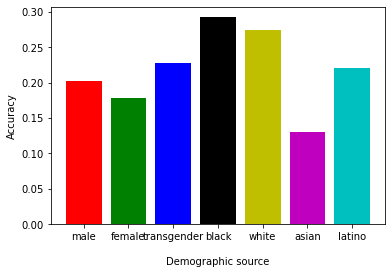

In [53]:
forBarPlot = model.PredictTestSetDemographic(test_data)
plt.figure()
x = forBarPlot[:,1]
y = np.array(forBarPlot[:,0].astype(float))
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='rgbkymc')
plt.xlabel("\nDemographic source")
plt.ylabel("Accuracy")
plt.xticks(x_pos, x)
plt.show()

In [54]:
forBarPlot

array([['0.20224281598006386', 'male'],
       ['0.1786521935775667', 'female'],
       ['0.22782874617737003', 'transgender'],
       ['0.2924131829241318', 'black'],
       ['0.2748283148441627', 'white'],
       ['0.1297709923664122', 'asian'],
       ['0.2210953346855984', 'latino']], dtype='<U32')

In [11]:
np.std(forBarPlot[:,0].astype(float))

0.051097952823252225

In [12]:
print("Antal toxic i predictions: ", sum(predictions))
print("Antal toxic i test set: ", sum(Y_test))
print("Samples i test set: ", len(Y_test))

Antal toxic i predictions:  [527.]
Antal toxic i test set:  [4417.]
Samples i test set:  35082
